# LIGHTGBM
https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

Control Params | Core Params | Metric Params | IO Params
-------------- | ----------- | ------------- | ---------
max_depth | task | metric (mae, mse, binary_logloss, multi_logloss) | max_bin
min_data_in_leaf | application (regression, binary, multiclass)| categorical_feature
feature_fraction | boosting (gbdt, rf, dark, goss) | ignore_column
bagging_fraction | num_boost_round | save_binary
early_stopping_round | learning_rate
lambda | num_leaves
min_gain_to_split | device (GPU or CPU)
max_cat_group | 

In [1]:
%load_ext chime
%matplotlib inline

import os
from glob import glob
import pickle
import chime

from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, classification_report
from skimage.exposure import adjust_sigmoid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import rasterio as rio
from rasterio.windows import from_bounds

import pandas as pd
import geopandas as gpd
import numpy as np

from datetime import datetime
import json

import matplotlib.pyplot as plt
import lightgbm as lgb

import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from utils import *

import optuna.integration.lightgbm as olgb

In [2]:
def calcMeanDiffs(df, headers):
    df["REDness"] = df.apply(lambda r: calcMeanDiff(r, "RED"), axis=1)
    df["GREENness"] = df.apply(lambda r: calcMeanDiff(r, "GREEN"), axis=1)
    df["BLUEness"] = df.apply(lambda r: calcMeanDiff(r, "BLUE"), axis=1)
    df["NIRness"] = df.apply(lambda r: calcMeanDiff(r, "NIR"), axis=1)
    df["BaseMean"] = df.apply(lambda r: np.mean([r.RED, r.GREEN, r.BLUE, r.NIR]), axis=1)
    if "REDness" not in headers:
        headers += ["REDness", "GREENness", "BLUEness", "NIRness", "BaseMean"]
    return df, headers

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return np.mean(errors), accuracy


def buildModel(params, dataset, features, classCol, fullReport=False, writeOut=False):
    """ Given parameters, a pandas dataframe, a list of feature column names, and the name of the class column"""
    X = dataset[features]
    y = dataset[classCol]
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.25, random_state=7)
    train_data = lgb.Dataset(X_train, label=Y_train)
    valid_data = lgb.Dataset(X_valid, label=Y_valid, reference=train_data)
    gbmModel = lgb.LGBMClassifier(**params, metric="custom")
    
    gbmModel.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), eval_metric=evalF1, early_stopping_rounds=50)#, verbose_eval=False)
    
    preds = gbmModel.predict(X_valid)

    scores = {}
    f1 = f1_score(Y_valid, preds, average='weighted')

    scores["F1"] = f1
    
    if fullReport:
        accuracy = accuracy_score(Y_valid, preds)
        kappa = cohen_kappa_score(Y_valid, preds)
        print(f"Model:\n\tAccuracy: {accuracy}\n\tF1: {f1}\n\tCohensKappa: {kappa}")
        print(classification_report(Y_valid, preds, target_names=[k for k,v in values_2019_lookup.items()][:-2]))#
        plotConfusionMatrix(gbmModel, X_valid, Y_valid)
    if writeOut:
        day = datetime.strftime(datetime.now(), "%Y%m%d")
        model_name = f"lightGBM_{day}.sav"
        model_path = os.path.join(os.path.abspath("./Models"), model_name)
        pickle.dump(gbmModel, open(model_path, "wb"))
        params_path = f"./Models/LGBMClassifierParams_{day}.txt"
        with open(params_path, "w+") as txt:
            txt.write(json.dumps(params))
        print(f"Wrote out trained model to \n\t{model_path} and paramameters to \n\t{params_path}")
    
    return gbmModel, scores


def optunaObjective(trial):
    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "multi_logloss")
    
    search_params = {
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 0.5),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 0.5),
        "num_leaves": trial.suggest_int("num_leaves", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 10, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
        "num_boost_round": trial.suggest_int("num_boost_round", 25, 400), # change min limit to 25 because best fits were hitting limit of 50 
        "boosting_type": trial.suggest_categorical('boosting_type', ["rf", "gbdt"]), # used dart on previous searches. not best for this
        "n_estimators": trial.suggest_int("n_estimators", 100, 500)
    }
    
    params = {**fixed_params, **search_params}
    scores = []
    for data in subGroups:
        #data = subGroups[i]
        gbm, modelScores = buildModel(params, data, featureHeaders, class_col)
                
        #preds = gbm.predict(X_valid)
        #accuracy = accuracy_score(y_valid, preds)
        #f1 = f1_score(y_valid, preds, average='weighted')
        scores.append(modelScores["F1"])
        
    meanScore = np.mean(scores)
    
    return meanScore


def evaluate_macroF1_lgb(truth, predictions):  
    #pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='weighted')
    return ('macroF1', f1, True) 


def plotConfusionMatrix(model, xValid, yValid):
    labels, counts = np.unique(yValid, return_counts=True)
    pred_lgb = model.predict(xValid)
    cm = confusion_matrix(yValid, pred_lgb, labels=labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)


    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=[k for i in labels for k,v in values_2019_lookup.items() if i == v],
           yticklabels=[k for i in labels for k,v in values_2019_lookup.items() if i == v],
           title='Normalized Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')


    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.4f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


def evalF1(y_true, y_pred):
    #https://stackoverflow.com/questions/57222667/light-gbm-early-stopping-does-not-work-for-custom-metric
    # returns (eval_name, eval_result, is_higher_better
    y_pred = y_pred.reshape(len(np.unique(y_true)),-1).argmax(axis=0)
    return 'F1', f1_score(y_true, y_pred, average='weighted'), True

In [3]:
trainingSamples_locs = {'PondLake': '../OtherData/TrainingData/PondLake_20210519.pickle',
                        'Pool': '../OtherData/TrainingData/Pool_20210519.pickle',
                        'DenseVeg': '../OtherData/TrainingData/DenseVeg_20210519.pickle',
                        'IrrigatedLand': '../OtherData/TrainingData/IrrigatedLand_20210519.pickle',
                        'Asphault': '../OtherData/TrainingData/Asphault_20210519.pickle',
                        'Impervious': '../OtherData/TrainingData/Impervious_20210519.pickle',
                        'Structure': '../OtherData/TrainingData/Structure_20210519.pickle',
                        'Barren': '../OtherData/TrainingData/Barren_20210519.pickle',
                        'SparseVeg': '../OtherData/TrainingData/SparseVeg_20210519.pickle',
                        'ParkingLot': '../OtherData/TrainingData/ParkingLot_20210519.pickle',
                        'Sidewalk': '../OtherData/TrainingData/Sidewalk_20210519.pickle'}

values_2019_lookup = {'PondLake': 1, 'Pool': 2, 'Barren': 3, 'SparseVeg': 4, 'DenseVeg': 5, 'IrrigatedLand': 6, 'Asphault': 7, 'Impervious': 8, 'Structure': 9, "ParkingLot": 7, "Sidewalk": 8}

trainingSamples_locs

{'PondLake': '../OtherData/TrainingData/PondLake_20210519.pickle',
 'Pool': '../OtherData/TrainingData/Pool_20210519.pickle',
 'DenseVeg': '../OtherData/TrainingData/DenseVeg_20210519.pickle',
 'IrrigatedLand': '../OtherData/TrainingData/IrrigatedLand_20210519.pickle',
 'Asphault': '../OtherData/TrainingData/Asphault_20210519.pickle',
 'Impervious': '../OtherData/TrainingData/Impervious_20210519.pickle',
 'Structure': '../OtherData/TrainingData/Structure_20210519.pickle',
 'Barren': '../OtherData/TrainingData/Barren_20210519.pickle',
 'SparseVeg': '../OtherData/TrainingData/SparseVeg_20210519.pickle',
 'ParkingLot': '../OtherData/TrainingData/ParkingLot_20210519.pickle',
 'Sidewalk': '../OtherData/TrainingData/Sidewalk_20210519.pickle'}

In [4]:
class_col = "LCClassInt"

trainingSamples = []
for lcClass, file in trainingSamples_locs.items():
    df = pd.read_pickle(file)
    if lcClass == "Structure":
        df = df[df.HAG >= 6]
        
    if lcClass == "PondLake" or lcClass == "Pool" or lcClass == "IrrigatedLand" or lcClass == "Impervious" or lcClass == "Barren" or lcClass == "Asphault":
        df = df[df.HAG == 0] 
        
    if lcClass == "PondLake":
        df = df[df.MSAVI < (120/255)*np.iinfo(np.uint16).max]
        df = df[df.NDVI < (15/255)*np.iinfo(np.uint16).max]
        
    if lcClass == "Pool":
        df = df[df.MSAVI < (100/255)*np.iinfo(np.uint16).max]
        df = df[df.NDVI < (65/255)*np.iinfo(np.uint16).max]
        
    if lcClass == "Asphault" or lcClass == "ParkingLot":
        df.loc[df.NIR >= (100/255)*np.iinfo(np.uint16).max, "LCClass"] = "Impervious"
        
    trainingSamples.append(df)
    
trainingSamples = pd.concat(trainingSamples).reset_index(drop=True)

print(trainingSamples.shape)

trainingSamples[class_col] = trainingSamples['LCClass'].apply(lambda lcc: values_2019_lookup[lcc])

local_class_weight_dict = {'PondLake': 0.02,
                           'Pool': 0.10,
                           'Barren': 24,
                           'SparseVeg': 18,
                           'DenseVeg': 15,
                           'IrrigatedLand': 3,
                           'Asphault': 11,
                           'Impervious': 14,
                           'Structure': 14.88}

# replace human readable names with numerical associations
local_class_weight_dict = { values_2019_lookup[k]: v for k, v in local_class_weight_dict.items() }

print(f"Total weights: {np.sum([v for v in local_class_weight_dict.values()])}")

%chime

(39980799, 26)
Total weights: 100.0


In [7]:
trainingFeaturesToUse = trainingSamples.columns.tolist()
trainingFeaturesToUse = [fn for fn in trainingFeaturesToUse if "GaussianSigma5" not in fn]
trainingFeaturesToUse = [fn for fn in trainingFeaturesToUse if "Segment_" not in fn]
trainingFeaturesToUse.remove("LCClass")
trainingFeaturesToUse.remove("LCClassInt")
trainingFeaturesToUse

['RED',
 'GREEN',
 'BLUE',
 'NIR',
 'MSAVI',
 'NDVI',
 'NDPI',
 'REDness',
 'GREENness',
 'BLUEness',
 'NIRness',
 'HAG',
 'DPR',
 'GaussianSigma2_RED',
 'GaussianSigma2_GREEN',
 'GaussianSigma2_BLUE',
 'GaussianSigma2_NIR']

In [8]:
trainingSamples.LCClass.value_counts()

Impervious       5578105
SparseVeg        5156222
Structure        4741328
Barren           4701539
IrrigatedLand    4440013
DenseVeg         4274182
Asphault         4260472
Pool             2801571
ParkingLot       2458928
Sidewalk         1053878
PondLake          514561
Name: LCClass, dtype: int64

In [9]:
%%time
subGroups = []
sampleSize = 200000
#sampleSize = min(10**6, trainingSamples.LCClassInt.value_counts().min()) # large sample size did not improve classification

for i in range(3):
    start = datetime.now()
    trainingSamples_sub = getSubSample(data=trainingSamples, maxSampSize=sampleSize, features_cols=trainingFeaturesToUse[:], class_column=class_col)
    trainingSamples_sub["RGBNmean"] = trainingSamples_sub.apply(lambda r: np.nanmean([r.RED, r.GREEN, r.BLUE, r.NIR]), axis=1)
    subGroups.append(trainingSamples_sub)
    print(f"Done {i} - {datetime.now()-start}")
    
%chime

featureHeaders = trainingFeaturesToUse[:]

fixed_params = {
    "early_stopping_rounds": 50, # changed from 75 to 50 on 2021-06-02. Potential speed up and possible overfitting at 75
    "bagging_freq": 5,
    "min_data_in_leaf": int(0.005*sampleSize),
    "n_jobs": 8,
    "random_state": 7,
    "verbose": -1,
    "class_weight": local_class_weight_dict
}

Done 0 - 0:01:31.392494
Done 1 - 0:01:32.513108
Done 2 - 0:01:32.759856
Wall time: 4min 36s


In [36]:
%%time

optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
    direction="maximize")

study.optimize(optunaObjective, n_trials=70)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
%chime

[24]	valid_0's F1: 0.974187
[25]	valid_0's F1: 0.974544
[26]	valid_0's F1: 0.974822
[27]	valid_0's F1: 0.97495
[28]	valid_0's F1: 0.975096
[29]	valid_0's F1: 0.975277
[30]	valid_0's F1: 0.975605
[31]	valid_0's F1: 0.975845
[32]	valid_0's F1: 0.976074
[33]	valid_0's F1: 0.976298
[34]	valid_0's F1: 0.976587
[35]	valid_0's F1: 0.976831
[36]	valid_0's F1: 0.977061
[37]	valid_0's F1: 0.977107
[38]	valid_0's F1: 0.977099
[39]	valid_0's F1: 0.977358
[40]	valid_0's F1: 0.977514
[41]	valid_0's F1: 0.97767
[42]	valid_0's F1: 0.978259
[43]	valid_0's F1: 0.978485
[44]	valid_0's F1: 0.978564
[45]	valid_0's F1: 0.978692
[46]	valid_0's F1: 0.978857
[47]	valid_0's F1: 0.978996
[48]	valid_0's F1: 0.979123
[49]	valid_0's F1: 0.979283
[50]	valid_0's F1: 0.979461
[51]	valid_0's F1: 0.979717
[52]	valid_0's F1: 0.979819
[53]	valid_0's F1: 0.980097
[54]	valid_0's F1: 0.980234
[55]	valid_0's F1: 0.980424
[56]	valid_0's F1: 0.980572
[57]	valid_0's F1: 0.980698
[58]	valid_0's F1: 0.980835
[59]	valid_0's F1: 0.9

In [37]:
history = study.trials_dataframe()
history["DurationSeconds"] = history.duration.apply(lambda d: d/np.timedelta64(1, 's'))
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f"Best trial:\n\tscore {best_score}\n\ttook {int(study.best_trial.duration.seconds/60)} minutes {study.best_trial.duration.seconds%60} seconds\n\tparams {json.dumps(best_params, indent=10)}")

Best trial:
	score 0.99104584722834
	took 75 minutes 4 seconds
	params {
          "feature_fraction": 0.43456715277058805,
          "bagging_fraction": 0.3680043367367479,
          "num_leaves": 455,
          "max_depth": 31,
          "learning_rate": 0.03221096244095838,
          "num_boost_round": 362,
          "boosting_type": "gbdt",
          "n_estimators": 355
}


In [47]:
history.head()

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_boosting_type,params_feature_fraction,params_learning_rate,params_max_depth,params_n_estimators,params_num_boost_round,params_num_leaves,state,DurationSeconds
0,0,0.972690,2021-06-07 16:57:52.706574,2021-06-07 17:07:49.189201,0 days 00:09:56.482627,0.126339,rf,0.462684,0.006365,95,476,392,406,COMPLETE,596.482627
1,1,0.972167,2021-06-07 17:07:49.189201,2021-06-07 17:19:45.686385,0 days 00:11:56.497184,0.253431,gbdt,0.392667,0.094725,91,388,337,433,COMPLETE,716.497184
2,2,0.975992,2021-06-07 17:19:45.687386,2021-06-07 18:35:42.576030,0 days 01:15:56.888644,0.356372,gbdt,0.345120,0.006919,24,277,374,365,COMPLETE,4556.888644
3,3,0.972498,2021-06-07 18:35:42.576030,2021-06-07 18:42:16.605273,0 days 00:06:34.029243,0.230731,rf,0.410547,0.011045,38,455,151,154,COMPLETE,394.029243
4,4,0.984456,2021-06-07 18:42:16.605273,2021-06-07 19:15:36.698791,0 days 00:33:20.093518,0.281611,gbdt,0.383549,0.017823,10,423,244,177,COMPLETE,2000.093518


In [57]:
best_performers = history[(history.value>(best_score-0.3)) & (history.DurationSeconds < 3000)]
highestAccuracy = history[history.value == history.value.max()]
highAccuracyLowRun = history[(history.DurationSeconds < highestAccuracy.DurationSeconds.max()*1.5) & (history.value > best_score * 0.95)]
optimum_trial = best_performers[best_performers.value == best_performers.value.max()] 
optimum_trial_number = optimum_trial.number.values[0]
optimum_score = optimum_trial.value.values[0]
optimum_time = optimum_trial.DurationSeconds.values[0]
optimum_params = study.get_trials()[optimum_trial_number].params
print(f"Optimum trial (#{optimum_trial_number}): \n\tscore {optimum_score} \n\ttook {int(optimum_time/60)} minutes {optimum_time%60} seconds \n\tparams: {json.dumps(optimum_params, indent=10)}")

Optimum trial (#59): 
	score 0.9892077947686301 
	took 45 minutes 19.630393999999797 seconds 
	params: {
          "feature_fraction": 0.46467865930725555,
          "bagging_fraction": 0.41130211914170145,
          "num_leaves": 429,
          "max_depth": 48,
          "learning_rate": 0.03583628750762444,
          "num_boost_round": 261,
          "boosting_type": "gbdt",
          "n_estimators": 276
}


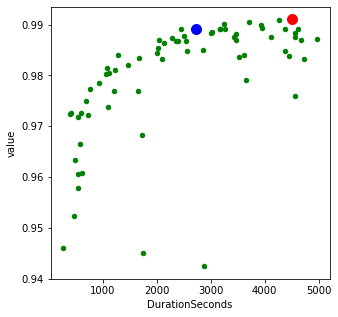

In [58]:
ax1 = highAccuracyLowRun.plot(kind='scatter', x='DurationSeconds', y='value', color='green', s=20, figsize=(5,5))    
ax2 = highestAccuracy.plot(kind='scatter', x='DurationSeconds', y='value', color='red', s=100, ax=ax1)
ax3 = optimum_trial.plot(kind='scatter', x='DurationSeconds', y='value', color='blue', s=100, ax=ax1)

In [59]:
trainingFeaturesToUse

['RED',
 'GREEN',
 'BLUE',
 'NIR',
 'MSAVI',
 'NDVI',
 'NDPI',
 'REDness',
 'GREENness',
 'BLUEness',
 'NIRness',
 'HAG',
 'DPR',
 'GaussianSigma2_RED',
 'GaussianSigma2_GREEN',
 'GaussianSigma2_BLUE',
 'GaussianSigma2_NIR']

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.46467865930725555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46467865930725555
[LightGBM] [Warning] min_data_in_leaf is set=2572, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2572
[LightGBM] [Warning] bagging_fraction is set=0.41130211914170145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41130211914170145
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] num_iterations is set=261, num_boost_round=261 will be ignored. Current value: num_iterations=261
[1]	valid_0's F1: 0.201616
Training until validation scores don't improve for 50 rounds
[2]	valid_0's F1: 0.278985
[3]	valid_0's F1: 0.774459
[4]	valid_0's F1: 0.832333
[5]	valid_0's F1: 0.934373
[6]	valid_0'

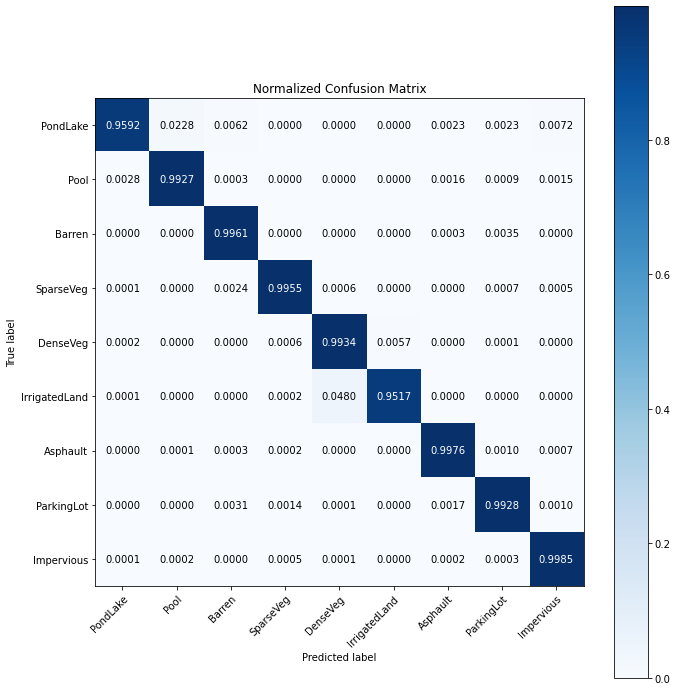

In [60]:
%%time
sampsize = min(10**6, trainingSamples.LCClassInt.value_counts().min())
final_optimum_params = {**fixed_params, **optimum_params}
subSampForFit = getSubSample(data=trainingSamples, sampSize=sampsize, features_cols=trainingFeaturesToUse, class_column=class_col)
subSampForFit["RGBNmean"] = subSampForFit.apply(lambda r: np.nanmean([r.RED, r.GREEN, r.BLUE, r.NIR]), axis=1)

optimumlgbm_model, scores = 
(final_optimum_params, subSampForFit, featureHeaders, class_col, fullReport=True, writeOut=True)


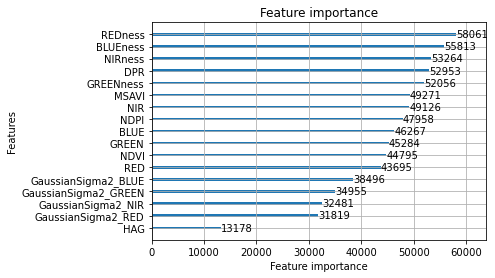

In [61]:
lgb.plot_importance(optimumlgbm_model)

In [62]:
finished()

## 5/19 Best Model

In [66]:
best_performers = history[(history.value>(best_score-0.03)) & (history.DurationSeconds < 180)]
highestAccuracy = history[history.value == history.value.max()]
highAccuracyLowRun = history[(history.DurationSeconds < highestAccuracy.DurationSeconds.max()*1.5) & (history.value > best_score * 0.95)]
optimum_trial = best_performers[best_performers.value == best_performers.value.max()] 
optimum_trial_number = optimum_trial.number.values[0]
optimum_score = optimum_trial.value.values[0]
optimum_time = optimum_trial.DurationSeconds.values[0]
optimum_params = study.get_trials()[optimum_trial_number].params
print(f"Optimum trial (#{optimum_trial_number}): \n\tscore {optimum_score} \n\ttook {int(optimum_time/60)} minutes {optimum_time%60} seconds \n\tparams: {json.dumps(optimum_params, indent=10)}")

Optimum trial (#14): 
	score 0.9457121900889948 
	took 1 minutes 53.977389 seconds 
	params: {
          "feature_fraction": 0.45147944998417966,
          "bagging_fraction": 0.4949143006815773,
          "num_leaves": 208,
          "max_depth": 27,
          "learning_rate": 0.05413473489373892,
          "num_boost_round": 50,
          "boosting_type": "gbdt",
          "n_estimators": 167
}


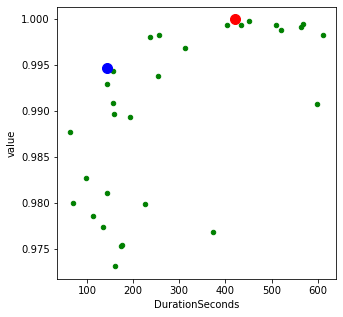

In [31]:
ax1 = highAccuracyLowRun.plot(kind='scatter', x='DurationSeconds', y='value', color='green', s=20, figsize=(5,5))    
ax2 = highestAccuracy.plot(kind='scatter', x='DurationSeconds', y='value', color='red', s=100, ax=ax1)
ax3 = optimum_trial.plot(kind='scatter', x='DurationSeconds', y='value', color='blue', s=100, ax=ax1)

In [30]:
final_best_params = {**fixed_params, **best_params}

[36]	valid_0's multi_logloss: 0.468567
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 19
[37]	valid_0's multi_logloss: 0.464455
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 208 and max_depth = 27

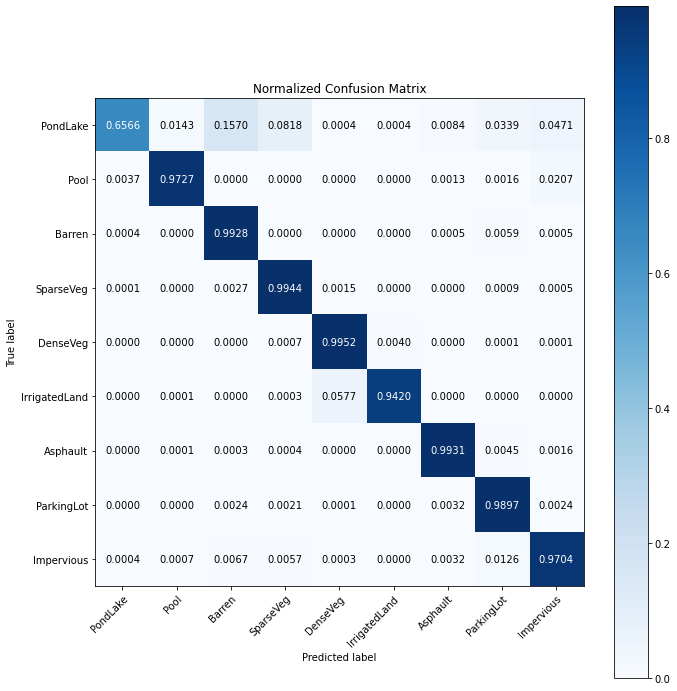

In [76]:
%%time
final_optimum_params = {**fixed_params, **optimum_params}
optimumlgbm_model = buildBestModel(final_optimum_params, pd.concat(subGroups))

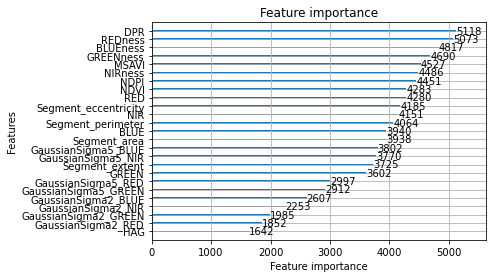

In [77]:
lgb.plot_importance(optimumlgbm_model)

In [401]:
%chime 